# EDA

In [1]:
import pybgpstream
import pandas as pd

## Cloudflare 1.1.1.1 incident on June 27, 2024

https://blog.cloudflare.com/cloudflare-1111-incident-on-june-27-2024/

Some of the difficulty comes from potential routing hijacks of 1.1.1.1. For example, if some fictitious FooBar Networks assigns 1.1.1.1/32 to one of their routers and shares this prefix within their internal network, their customers will have difficulty routing to the 1.1.1.1 DNS service. If they advertise the 1.1.1.1/32 prefix outside their immediate network, the impact can be even greater. The reason 1.1.1.1/32 would be selected instead of the 1.1.1.0/24 BGP-announced by Cloudflare is due to Longest Prefix Matching (LPM). While many prefixes in a route table could match the 1.1.1.1 address, such as 1.1.1.0/24, 1.1.1.0/29, and 1.1.1.1/32, 1.1.1.1/32 is considered the “longest match” by the LPM algorithm because it has the highest number of identical bits and longest subnet mask while matching the 1.1.1.1 address. In simple terms, we would call 1.1.1.1/32 the “most specific” route available to 1.1.1.1.

- **2024-06-27 18:51:00** `AS267613` (Eletronet) begins announcing 1.1.1.1/32 to peers, providers, and customers. 1.1.1.1/32 is announced with the AS267613 origin AS

- **2024-06-27 22:16:00** AS262504 leaks 1.1.1.0/24 again, attracting some traffic to a Cloudflare peering with `AS267613` in São Paulo. Some 1.1.1.1 requests as a result are returned with higher latency, but the hijack of 1.1.1.1/32 and traffic blackholing appears resolved

### Get data

In [2]:
# collector = "route-views.eqix"
# collector = "route-views.ny" 
# collector = "route-views.telxatl"
# collector = "route-views2.saopaulo"
# collector = "route-views.fortaleza"
collector = "route-views.amsix"

stream = pybgpstream.BGPStream(
    #project="route-views",          # Proyecto
    collectors  =   [collector],#     # Collector remoto
    record_type =   "updates",             # "ribs" o "updates"
    from_time   =   "2024-06-27 18:00:00",  # Inicio del rango
    until_time  =   "2024-06-27 22:30:00",     # Fin del rango (aquí 5 minutos)

)

""" rows = []

# Iterar sobre los registros en tiempo real o históricos
for rec in stream.records():
    for elem in rec:
        fields = elem.fields
        rows.append({
            "time": rec.time,
            "project": rec.project,
            "collector": rec.collector,
            "peer_asn": fields.get("peer-asn"),
            "peer_ip": fields.get("peer-address"),
            "type": elem.type,           # "RIB", "A" (announce), "W" (withdraw)
            "prefix": fields.get("prefix"),
            "next_hop": fields.get("next-hop"),
            "as_path": fields.get("as-path"),
            "origin": fields.get("origin"),
            "local_pref": fields.get("local-pref"),
            "med": fields.get("med"),
            "communities": fields.get("communities"),
        }) """

rows = []

for rec in stream.records():
    for elem in rec:
        f = elem.fields  # solo atributos BGP (no peers)

        # Para retiros (W) no hay as-path/next-hop/etc.
        is_announce = (elem.type == 'A')

        rows.append({
            "time": rec.time,                        # epoch (int)
            "project": rec.project,                  # p.ej. "route-views"
            "collector": rec.collector,              # p.ej. "route-views.sg"
            "peer_asn": elem.peer_asn,               # <--- AQUÍ
            "peer_ip": elem.peer_address,            # <--- AQUÍ
            "type": elem.type,                       # "A" o "W"
            "prefix": f.get("prefix"),
            "next_hop": f.get("next-hop") if is_announce else None,
            "as_path": f.get("as-path")  if is_announce else None,
            "origin": f.get("origin")    if is_announce else None,
            "local_pref": f.get("local-pref") if is_announce else None,
            "med": f.get("med")                  if is_announce else None,
            "communities": f.get("communities") if is_announce else None,
        })

# Convertir a DataFrame
df = pd.DataFrame(rows)

#pd.set_option('display.max_rows', None)

print(f'Dataframe with {len(df):,} rows')

Dataframe with 11,628,213 rows


In [3]:
df['formatted_time'] = pd.to_datetime(df['time'], unit='s', utc=True)
df['formatted_time'] = df['formatted_time'].dt.strftime('%Y-%m-%d %H:%M:%S')
df.head(5)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1070::/32,2001:7f8:1:0:a500:26:7613:1,267613 28209,None,None,None,"{5469:11111, 5469:2400, 5469:10110}",2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2804:1624:9000::/36,2001:7f8:1:0:a500:26:7613:1,267613 174 263444 263270,None,None,None,"{5469:10850, 5469:11000, 5469:2200}",2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.amsix,267613,2001:7f8:1:0:a500:26:7613:1,A,2a06:de05:61dc::/48,2001:7f8:1:0:a500:26:7613:1,267613 1299 174 53667,None,None,None,"{5469:10850, 5469:11000, 5469:2200}",2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.amsix,56662,2001:7f8:f2:e1:0:a105:6662:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:a105:6662:1,56662 34549 3257 174 53667,None,None,None,{56662:65008},2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.amsix,213151,2001:7f8:f2:e1:0:21:3151:1,A,2a06:de05:61dc::/48,2001:7f8:f2:e1:0:21:3151:1,213151 34549 3257 174 53667,None,None,None,{},2024-06-27 18:00:00


#### Save data

In [4]:
df.to_parquet(f'/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024_{collector}.parquet',
              engine='pyarrow',
              compression='zstd')

In [5]:
del df

### Load data from file

In [2]:
df_parquet = pd.read_parquet('/home/chris/projects/BGP Hijacking detection/data/raw/cloudflare_june_27_2024.parquet',
                             engine='pyarrow')

In [3]:
df_parquet.head(10)

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
0,1.719511e+09,routeviews,route-views.sg,18106,27.111.228.6,A,130.137.150.0/24,27.111.228.6,18106 2914 16509,None,None,None,[2914:2000],2024-06-27 18:00:00
1,1.719511e+09,routeviews,route-views.sg,18106,2001:de8:4::1:8106:1,A,2803:a5c0:4000::/36,2001:de8:4::1:8106:1,18106 2914 1299 262589 262186 273001,None,None,None,[2914:3000],2024-06-27 18:00:00
2,1.719511e+09,routeviews,route-views.sg,38880,2001:de8:4::3:8880:1,W,2a10:ccc7:9367::/48,None,None,None,None,None,None,2024-06-27 18:00:00
3,1.719511e+09,routeviews,route-views.sg,38880,2001:de8:4::3:8880:1,A,2a10:ccc7:9367::/48,2001:de8:4::3:8880:1,38880 4826 20473,None,None,None,[],2024-06-27 18:00:00
4,1.719511e+09,routeviews,route-views.sg,24516,27.111.229.111,A,169.145.140.0/23,27.111.229.111,24516 3491 3356 14114 6979 6979 6979 6979 6979...,None,None,None,"[3491:9080, 3491:9081, 14114:100, 14114:199, 2...",2024-06-27 18:00:00
5,1.719511e+09,routeviews,route-views.sg,24516,2001:de8:4::2:4516:2,A,2606:6e00:8000::/35,2001:de8:4::2:4516:2,24516 7296,None,None,None,"[24516:11001, 24516:11000, 7296:1000, 24516:14...",2024-06-27 18:00:00
6,1.719511e+09,routeviews,route-views.sg,16552,27.111.229.252,A,81.192.239.0/24,27.111.229.252,16552 4637 5511 6713 6713 6713 6713 6713 6713 ...,None,None,None,"[16552:9100, 4637:32314, 4637:32504, 16552:101...",2024-06-27 18:00:09
7,1.719511e+09,routeviews,route-views.sg,16552,27.111.229.252,A,45.172.92.0/22,27.111.229.252,16552 2914 6453 32098 17072 17072 17072 17072 ...,None,None,None,"[2914:420, 2914:3000, 2914:1001, 2914:2000, 16...",2024-06-27 18:00:09
8,1.719511e+09,routeviews,route-views.sg,16552,27.111.229.252,A,123.136.68.0/24,27.111.229.252,16552 23856 139883 23767,None,None,None,"[16552:9150, 24115:23856, 23856:30000, 16552:2...",2024-06-27 18:00:09
9,1.719511e+09,routeviews,route-views.sg,16552,27.111.229.252,A,192.122.140.0/24,27.111.229.252,16552 23856 139883 23767,None,None,None,"[16552:9150, 24115:23856, 23856:30000, 16552:2...",2024-06-27 18:00:09


In [4]:
df_parquet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12951898 entries, 0 to 12951897
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   time            float64
 1   project         object 
 2   collector       object 
 3   peer_asn        int64  
 4   peer_ip         object 
 5   type            object 
 6   prefix          object 
 7   next_hop        object 
 8   as_path         object 
 9   origin          object 
 10  local_pref      object 
 11  med             object 
 12  communities     object 
 13  formatted_time  object 
dtypes: float64(1), int64(1), object(12)
memory usage: 1.4+ GB


In [5]:
null_stats = pd.DataFrame({
    'nulos': df_parquet.isna().sum(),
    'no_nulos': df_parquet.notna().sum(),
    'pct_nulos': (df_parquet.isna().sum() / len(df_parquet) * 100).round(2)
})
print(null_stats)

                   nulos  no_nulos  pct_nulos
time                   0  12951898       0.00
project                0  12951898       0.00
collector              0  12951898       0.00
peer_asn               0  12951898       0.00
peer_ip                0  12951898       0.00
type                   0  12951898       0.00
prefix                 0  12951898       0.00
next_hop          876517  12075381       6.77
as_path           876517  12075381       6.77
origin          12951898         0     100.00
local_pref      12951898         0     100.00
med             12951898         0     100.00
communities       876517  12075381       6.77
formatted_time         0  12951898       0.00


In [6]:
df_parquet['prefix'].value_counts().to_frame()

,count
prefix,
169.145.140.0/23,139092
2600:40fc:1004::/48,58829
102.66.139.0/24,54295
2c0f:fda8::/32,34202
2606:6e00:8000::/35,30765
...,...
62.121.234.0/24,1
62.121.233.0/24,1
62.121.200.0/24,1


In [7]:
df_parquet[df_parquet['prefix'] == '1.1.1.1/32' ]

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time


In [9]:
df_parquet[df_parquet['as_path'].str.contains('267613', na=False)]

,time,project,collector,peer_asn,peer_ip,type,prefix,next_hop,as_path,origin,local_pref,med,communities,formatted_time
39191,1.719511e+09,routeviews,route-views.sg,199524,27.111.228.222,A,138.219.99.0/24,27.111.228.222,199524 2914 3356 267613 263922,None,None,None,[],2024-06-27 18:01:26
39192,1.719511e+09,routeviews,route-views.sg,199524,27.111.228.222,A,138.219.97.0/24,27.111.228.222,199524 2914 3356 267613 263922,None,None,None,[],2024-06-27 18:01:26
39193,1.719511e+09,routeviews,route-views.sg,199524,27.111.228.222,A,138.219.96.0/24,27.111.228.222,199524 2914 3356 267613 263922,None,None,None,[],2024-06-27 18:01:26
39941,1.719511e+09,routeviews,route-views.sg,3257,27.111.228.217,A,138.219.99.0/24,27.111.228.217,3257 174 267613 263922,None,None,None,"[3257:8838, 3257:30516, 3257:56601, 3257:56600...",2024-06-27 18:01:28
39942,1.719511e+09,routeviews,route-views.sg,3257,27.111.228.217,A,138.219.97.0/24,27.111.228.217,3257 174 267613 263922,None,None,None,"[3257:8838, 3257:30516, 3257:56601, 3257:56600...",2024-06-27 18:01:28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12940677,1.719527e+09,routeviews,route-views.sg,58511,27.111.229.175,A,200.152.24.0/24,27.111.229.175,58511 1299 267613 262462 272438 28590,None,None,None,"[58511:100, 58511:9005]",2024-06-27 22:29:35
12940831,1.719527e+09,routeviews,route-views.sg,58511,2001:de8:4::5:8511:1,A,2804:8cb8::/32,2001:de8:4::5:8511:1,58511 267613 273817,None,None,None,"[58511:200, 58511:9007]",2024-06-27 22:29:35
12945939,1.719527e+09,routeviews,route-views.sg,7713,27.111.228.155,A,200.152.24.0/24,27.111.228.155,7713 1299 267613 262462 272438 28590,None,None,None,[],2024-06-27 22:29:46
12947996,1.719527e+09,routeviews,route-views.sg,3257,27.111.228.217,A,200.152.24.0/24,27.111.228.217,3257 174 267613 262462 272438 28590,None,None,None,"[3257:8958, 3257:58520, 3257:58521, 3257:30996...",2024-06-27 22:29:53


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

,type,count
0,A,12075381
1,W,876517


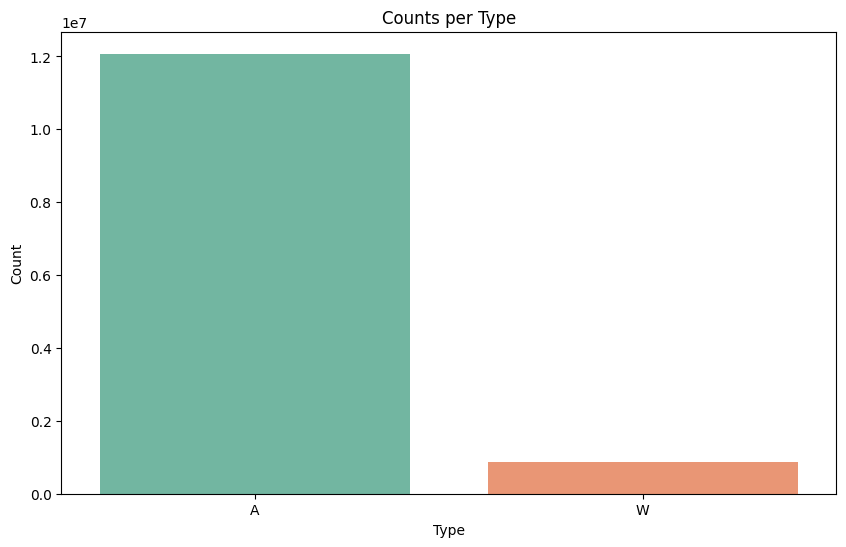

In [8]:
df_types = (
    df_parquet['type']
    .value_counts()
    .reset_index()
)

display(df_types)

plt.figure(figsize=(10,6))
ax = sns.barplot(data=df_types, x='type', y='count', palette='Set2', hue='type')
plt.title('Counts per Type')
plt.xlabel('Type')
plt.ylabel('Count')
plt.show()

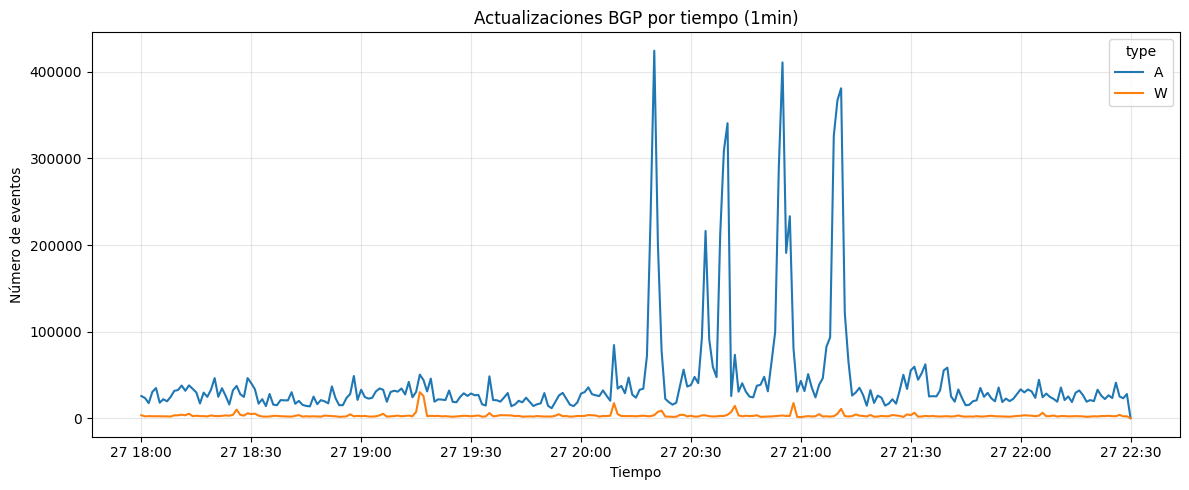

In [ ]:
# Intervalo de agregación: '1S', '1min', '5min', etc.
GRAIN = '1min'

# Agrega por tiempo (Grouper) y tipo (A/W) SIN el warning
df_time_dist = (
    df_parquet.groupby([pd.Grouper(key='formatted_time', freq=GRAIN), 'type'])
      .size()
      .reset_index(name='count')
)

# Gráfico con seaborn
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_time_dist, x='formatted_time', y='count', hue='type')
plt.title(f'Actualizaciones BGP por tiempo ({GRAIN})')
plt.xlabel('Tiempo')
plt.ylabel('Número de eventos')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [23]:
def plot_updates_by_type(df: pd.DataFrame, grain: str = "1min", group_col: str = None):
    """
    Grafica la distribución temporal de eventos BGP por tipo (A/W).
    
    Parámetros
    ----------
    df : pd.DataFrame
        Debe incluir las columnas: ['formatted_time', 'type'].
        'formatted_time' puede ser string '%Y-%m-%d %H:%M:%S' o datetime.
    grain : str
        Frecuencia de agregación temporal (p.ej. '1S', '1min', '5min', '1H').
    group_col : str, opcional
        Nombre de una columna del DataFrame. Si se especifica, se generará un
        gráfico por cada valor distinto de esa columna (small multiples).
        Si no se especifica, se grafica una sola serie agregada globalmente.

    Returns
    -------
    pd.DataFrame
        DataFrame agregado con columnas:
        - Si group_col es None: ['t', 'type', 'count']
        - Si group_col no es None: ['t', group_col, 'type', 'count']
    """

    if group_col is None:
        # Agregado global por tiempo y tipo
        agg = (
            df.groupby([pd.Grouper(key='formatted_time', freq=grain), 'type'])
                .size()
                .reset_index(name='count')
                .sort_values('formatted_time')
        )

        # Plot único (A vs W)
        plt.figure(figsize=(12, 5))
        sns.lineplot(data=agg, x='formatted_time', y='count', hue='type', estimator=None)
        plt.title(f'Eventos BGP por tipo (A/W) en el tiempo — {grain}')
        plt.xlabel('Tiempo'); plt.ylabel('Número de eventos')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    else:

        if isinstance(df[group_col].dtype, pd.CategoricalDtype):
            df[group_col] = df[group_col].cat.remove_unused_categories()
        # Agregado por tiempo, grupo y tipo
        agg = (
            df.groupby([pd.Grouper(key='formatted_time', freq=grain), group_col, 'type'])
                .size()
                .reset_index(name='count')
                .sort_values('formatted_time')
        )

        # Small multiples: un panel por valor de group_col
        g = sns.FacetGrid(
            agg, col=group_col, hue='type', sharey=False, sharex=True, col_wrap=3, height=3.2, aspect=1.6
        )
        g.map_dataframe(sns.lineplot, x='formatted_time', y='count', estimator=None)
        g.add_legend(title='type')
        g.set_xticklabels(rotation=30)
        g.set_axis_labels('Tiempo', 'Número de eventos')
        g.set_titles(col_template=f'{group_col} = {{col_name}}')
        for ax in g.axes.flatten():
            ax.grid(True, alpha=0.3)
        plt.subplots_adjust(top=0.88)
        g.fig.suptitle(f'Eventos BGP por tipo (A/W) en el tiempo — {grain}', y=1.02)
        plt.tight_layout()
        plt.show()

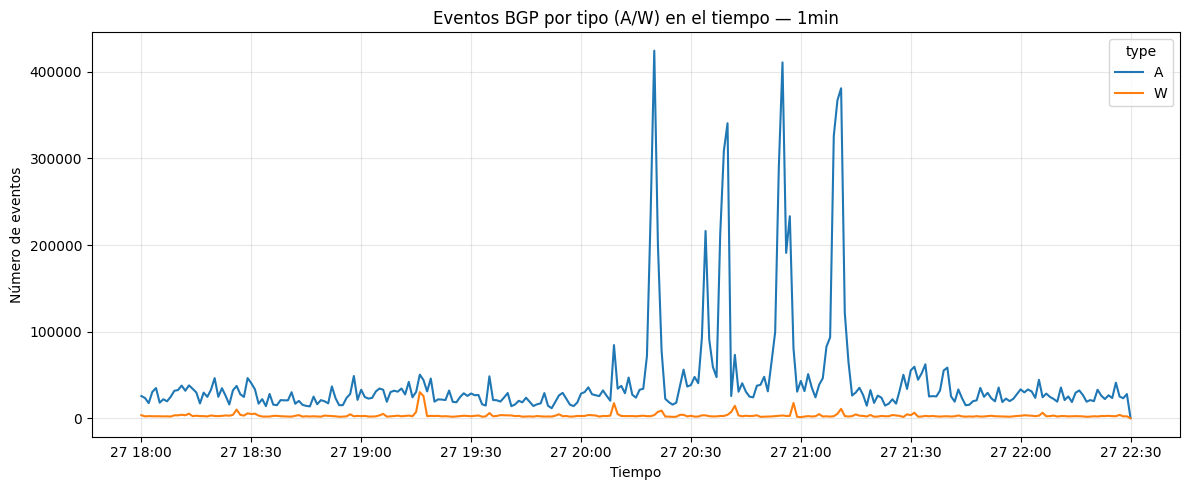

In [24]:
plot_updates_by_type(df_parquet, grain='1min')

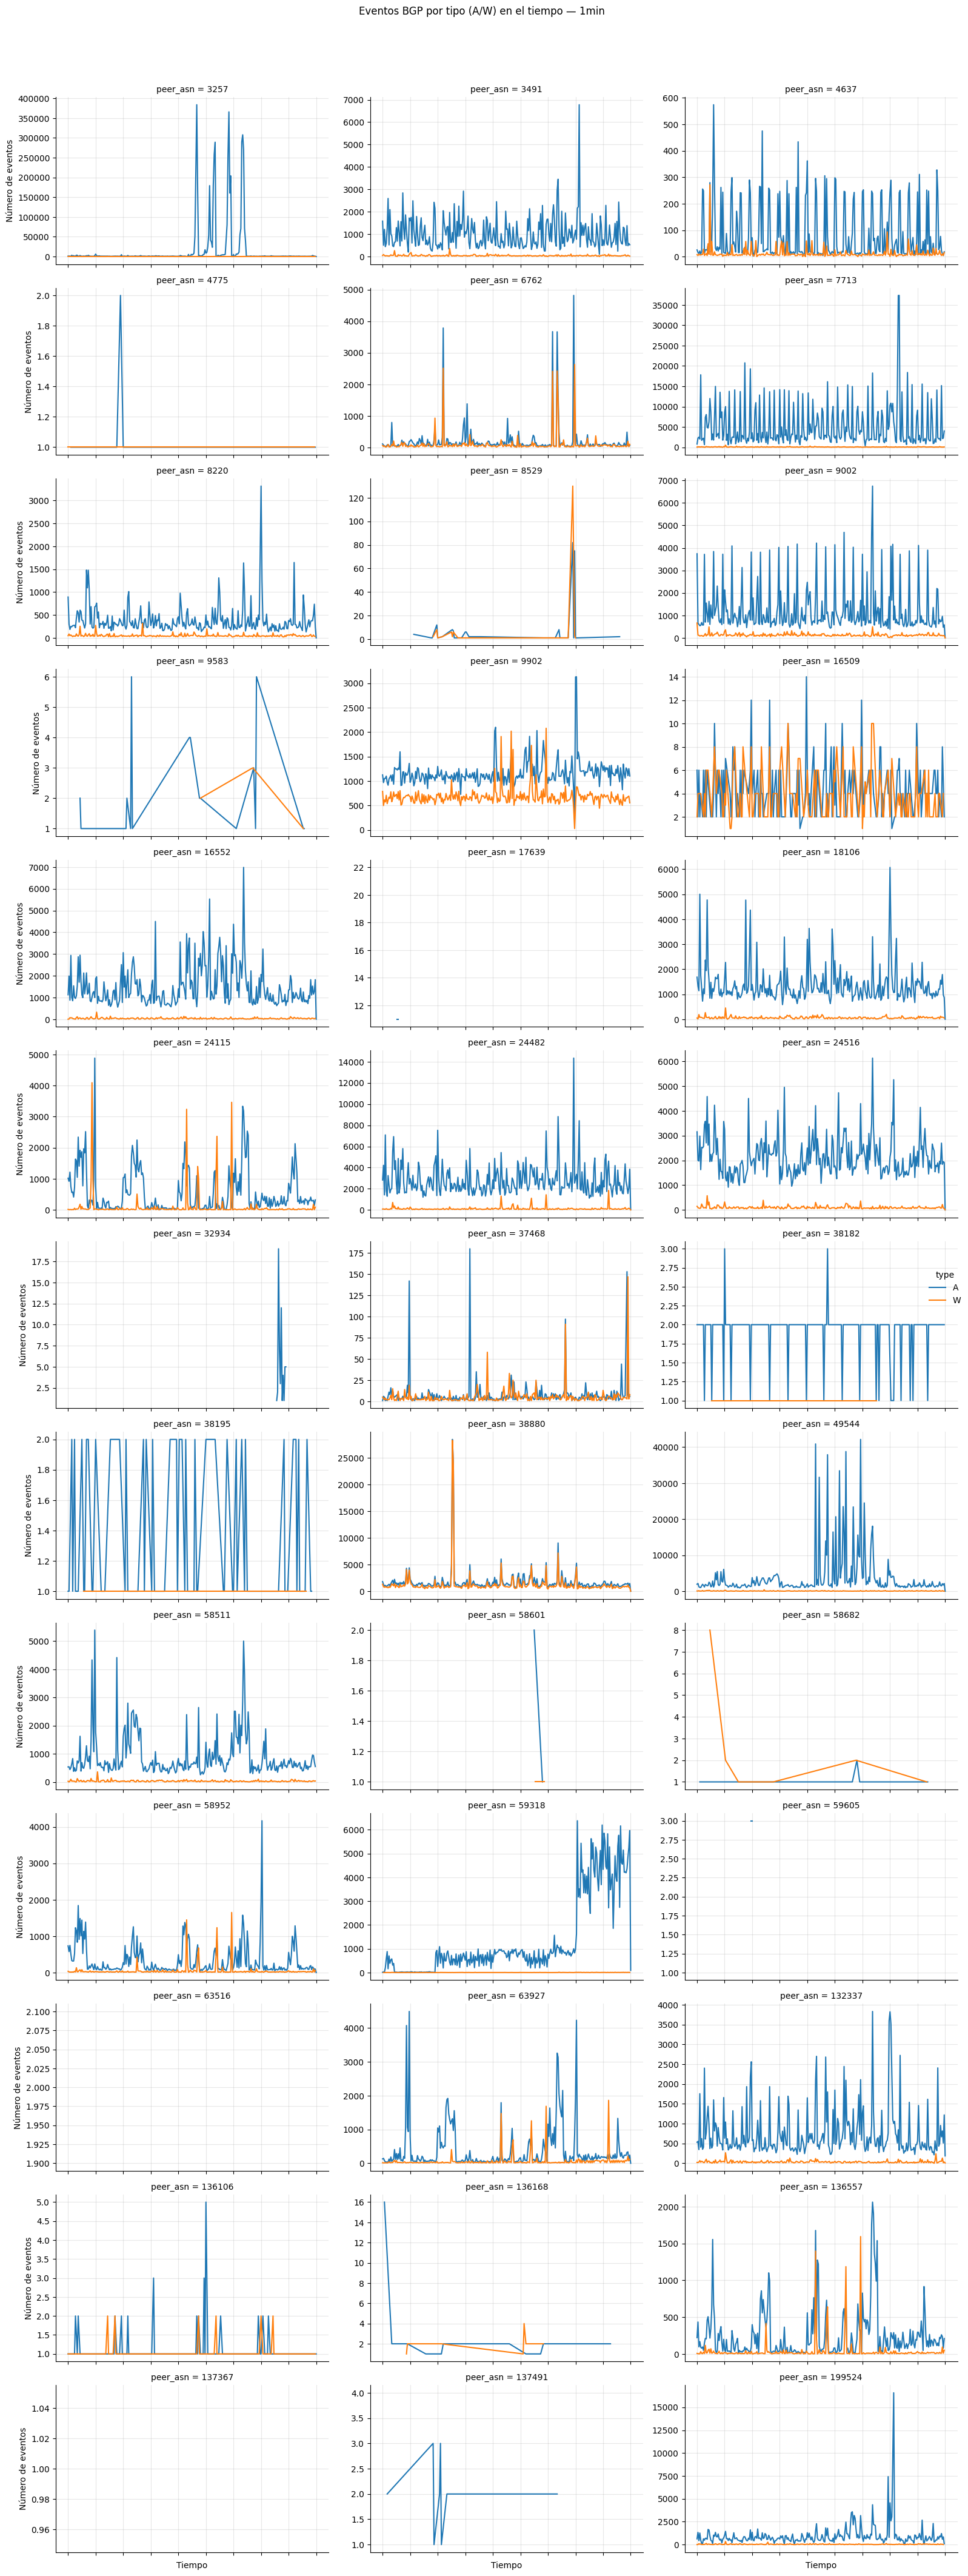

In [25]:
plot_updates_by_type(df_parquet, grain='1min', group_col='peer_asn')